<a href="https://colab.research.google.com/github/mdsiam135/ICCIT2025/blob/main/SVM(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# SVM Agricultural Production Classification - Step by Step Execution for Google Colab

# ========================================================================
# STEP 1: Import Required Libraries and Setup
# ========================================================================
print("STEP 1: Importing libraries and setting up environment...")
print("="*60)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           precision_score, recall_score, f1_score,
                           precision_recall_fscore_support)
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print("✅ Plot styling configured!")
print()


STEP 1: Importing libraries and setting up environment...
✅ All libraries imported successfully!
✅ Plot styling configured!



In [2]:

# ========================================================================
# STEP 2: Initialize the SVM Classifier Class
# ========================================================================
print("STEP 2: Initializing SVM Classifier Class...")
print("="*60)

class SVMProductionClassifier:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.label_mapping = {
            'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4
        }
        self.reverse_mapping = {v: k for k, v in self.label_mapping.items()}
        print("✅ SVM Classifier initialized!")
        print(f"✅ Label mapping: {self.label_mapping}")

    def load_and_preprocess_data(self, train_path, val_path, test_path):
        """Load and preprocess the datasets"""
        print("\nLoading datasets...")

        # Load datasets
        self.train_df = pd.read_csv(train_path)
        self.val_df = pd.read_csv(val_path)
        self.test_df = pd.read_csv(test_path)

        print(f"✅ Train dataset shape: {self.train_df.shape}")
        print(f"✅ Validation dataset shape: {self.val_df.shape}")
        print(f"✅ Test dataset shape: {self.test_df.shape}")

        # Show first few rows of training data
        print("\nFirst 5 rows of training data:")
        print(self.train_df.head())

        return self

    def _create_quantile_labels(self):
        """Create quantile-based labels for production values"""
        print("\nCreating quantile-based labels...")

        # Combine all production values to calculate consistent quantiles
        all_production = pd.concat([
            self.train_df['Production (M.Ton)'],
            self.val_df['Production (M.Ton)'],
            self.test_df['Production (M.Ton)']
        ])

        # Calculate quantiles
        quantiles = all_production.quantile([0.2, 0.4, 0.6, 0.8]).values
        print(f"✅ Quantile thresholds: {quantiles}")

        # Function to assign labels based on quantiles
        def assign_label(value):
            if value <= quantiles[0]:
                return 'Very Low'
            elif value <= quantiles[1]:
                return 'Low'
            elif value <= quantiles[2]:
                return 'Medium'
            elif value <= quantiles[3]:
                return 'High'
            else:
                return 'Very High'

        # Apply labeling to all datasets
        self.train_df['Production_Label'] = self.train_df['Production (M.Ton)'].apply(assign_label)
        self.val_df['Production_Label'] = self.val_df['Production (M.Ton)'].apply(assign_label)
        self.test_df['Production_Label'] = self.test_df['Production (M.Ton)'].apply(assign_label)

        # Print label distribution
        print("\n✅ Label distribution in training set:")
        label_counts = self.train_df['Production_Label'].value_counts().sort_index()
        print(label_counts)

        # Visualize label distribution
        plt.figure(figsize=(10, 6))
        label_counts.plot(kind='bar', color='skyblue', alpha=0.7)
        plt.title('Distribution of Production Labels in Training Set')
        plt.xlabel('Production Labels')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def _prepare_features_targets(self):
        """Prepare feature matrices and target vectors"""
        print("\nPreparing features and targets...")

        # Drop the target column and any non-numeric columns for features
        feature_columns = [col for col in self.train_df.columns
                          if col not in ['Production (M.Ton)', 'Production_Label']]

        print(f"✅ Feature columns: {feature_columns}")

        # Extract features
        self.X_train = self.train_df[feature_columns].values
        self.X_val = self.val_df[feature_columns].values
        self.X_test = self.test_df[feature_columns].values

        # Extract targets and convert to numeric
        self.y_train = self.train_df['Production_Label'].map(self.label_mapping).values
        self.y_val = self.val_df['Production_Label'].map(self.label_mapping).values
        self.y_test = self.test_df['Production_Label'].map(self.label_mapping).values

        print(f"✅ Feature matrix shape - Train: {self.X_train.shape}, Val: {self.X_val.shape}, Test: {self.X_test.shape}")
        print(f"✅ Target vector shape - Train: {self.y_train.shape}, Val: {self.y_val.shape}, Test: {self.y_test.shape}")

    def train_model(self, kernel='rbf', C=1.0, gamma='scale'):
        """Train the SVM model"""
        print(f"\nTraining SVM model with kernel={kernel}, C={C}, gamma={gamma}...")

        # Scale the features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_val_scaled = self.scaler.transform(self.X_val)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        print(f"✅ Features scaled successfully!")
        print(f"✅ Scaled training features shape: {self.X_train_scaled.shape}")

        # Initialize and train the model
        self.model = SVC(kernel=kernel, C=C, gamma=gamma, random_state=42)
        self.model.fit(self.X_train_scaled, self.y_train)

        print("✅ Model training completed!")
        return self

    def evaluate_model(self):
        """Comprehensive model evaluation"""
        print("\n" + "="*60)
        print("MODEL EVALUATION RESULTS")
        print("="*60)

        # Make predictions
        self.y_train_pred = self.model.predict(self.X_train_scaled)
        self.y_val_pred = self.model.predict(self.X_val_scaled)
        self.y_test_pred = self.model.predict(self.X_test_scaled)

        print("✅ Predictions generated for all datasets!")

        # Calculate metrics for all datasets
        datasets = {
            'Training': (self.y_train, self.y_train_pred),
            'Validation': (self.y_val, self.y_val_pred),
            'Testing': (self.y_test, self.y_test_pred)
        }

        self.metrics_results = {}

        for dataset_name, (y_true, y_pred) in datasets.items():
            print(f"\n{dataset_name} Set Metrics:")
            print("-" * 30)

            # Calculate metrics
            accuracy = accuracy_score(y_true, y_pred)
            precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
            recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
            f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
            precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
            recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
            f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

            # Store results
            self.metrics_results[dataset_name] = {
                'Accuracy': accuracy,
                'Precision (Macro)': precision_macro,
                'Recall (Macro)': recall_macro,
                'F1 Score (Macro)': f1_macro,
                'Precision (Weighted)': precision_weighted,
                'Recall (Weighted)': recall_weighted,
                'F1 Score (Weighted)': f1_weighted
            }

            # Print metrics
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision (Macro): {precision_macro:.4f}")
            print(f"Recall (Macro): {recall_macro:.4f}")
            print(f"F1 Score (Macro): {f1_macro:.4f}")
            print(f"Precision (Weighted): {precision_weighted:.4f}")
            print(f"Recall (Weighted): {recall_weighted:.4f}")
            print(f"F1 Score (Weighted): {f1_weighted:.4f}")

    def detailed_classification_report(self):
        """Generate detailed classification reports"""
        print("\n" + "="*60)
        print("DETAILED CLASSIFICATION REPORTS")
        print("="*60)

        datasets = {
            'Training': (self.y_train, self.y_train_pred),
            'Validation': (self.y_val, self.y_val_pred),
            'Testing': (self.y_test, self.y_test_pred)
        }

        target_names = [self.reverse_mapping[i] for i in range(5)]

        for dataset_name, (y_true, y_pred) in datasets.items():
            print(f"\n{dataset_name} Set Classification Report:")
            print("-" * 40)
            print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

    def plot_confusion_matrices(self):
        """Plot confusion matrices for all datasets"""
        print("\n" + "="*60)
        print("STEP 6: GENERATING CONFUSION MATRICES")
        print("="*60)

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        datasets = {
            'Training': (self.y_train, self.y_train_pred),
            'Validation': (self.y_val, self.y_val_pred),
            'Testing': (self.y_test, self.y_test_pred)
        }

        labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

        for idx, (dataset_name, (y_true, y_pred)) in enumerate(datasets.items()):
            cm = confusion_matrix(y_true, y_pred)

            print(f"✅ Confusion Matrix for {dataset_name} Set:")
            print(cm)
            print()

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=labels, yticklabels=labels, ax=axes[idx])
            axes[idx].set_title(f'Confusion Matrix - {dataset_name}')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')

        plt.tight_layout()
        plt.show()
        print("✅ Confusion matrices plotted successfully!")

    def plot_accuracy_comparison(self):
        """Plot accuracy comparison between training, validation, and testing"""
        print("\n" + "="*60)
        print("STEP 7: ACCURACY AND F1 SCORE COMPARISON")
        print("="*60)

        datasets = ['Training', 'Validation', 'Testing']
        accuracies = [self.metrics_results[ds]['Accuracy'] for ds in datasets]
        macro_f1_scores = [self.metrics_results[ds]['F1 Score (Macro)'] for ds in datasets]

        print("✅ Accuracy scores:", {ds: f"{acc:.4f}" for ds, acc in zip(datasets, accuracies)})
        print("✅ Macro F1 scores:", {ds: f"{f1:.4f}" for ds, f1 in zip(datasets, macro_f1_scores)})

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Accuracy comparison
        bars1 = ax1.bar(datasets, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8)
        ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Accuracy', fontsize=12)
        ax1.set_ylim(0, 1)

        # Add value labels on bars
        for bar, acc in zip(bars1, accuracies):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

        # Macro F1 Score comparison
        bars2 = ax2.bar(datasets, macro_f1_scores, color=['gold', 'orange', 'darkorange'], alpha=0.8)
        ax2.set_title('Macro F1 Score Comparison', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Macro F1 Score', fontsize=12)
        ax2.set_ylim(0, 1)

        # Add value labels on bars
        for bar, f1 in zip(bars2, macro_f1_scores):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()
        print("✅ Accuracy and F1 score comparison plotted successfully!")

    def plot_learning_curves(self):
        """Plot learning curves to show training vs validation performance over different training sizes"""
        print("\n" + "="*60)
        print("STEP 8: GENERATING LEARNING CURVES")
        print("="*60)

        print("Generating learning curves...")

        # Generate learning curves
        train_sizes, train_scores, val_scores = learning_curve(
            self.model, self.X_train_scaled, self.y_train,
            cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
            scoring='accuracy', random_state=42
        )

        # Calculate means and standard deviations
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)

        print(f"✅ Learning curve data generated!")
        print(f"✅ Training sizes: {train_sizes}")
        print(f"✅ Final training accuracy: {train_mean[-1]:.4f} ± {train_std[-1]:.4f}")
        print(f"✅ Final validation accuracy: {val_mean[-1]:.4f} ± {val_std[-1]:.4f}")

        # Plot learning curves
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
        plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Accuracy')
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

        plt.title('Learning Curves - Training vs Validation Accuracy', fontsize=14, fontweight='bold')
        plt.xlabel('Training Set Size')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)

        # Plot metrics summary
        plt.subplot(2, 1, 2)
        metrics = ['Accuracy', 'F1 Score (Macro)', 'Precision (Macro)', 'Recall (Macro)']
        train_vals = [self.metrics_results['Training'][metric] for metric in metrics]
        val_vals = [self.metrics_results['Validation'][metric] for metric in metrics]
        test_vals = [self.metrics_results['Testing'][metric] for metric in metrics]

        x = np.arange(len(metrics))
        width = 0.25

        plt.bar(x - width, train_vals, width, label='Training', alpha=0.8)
        plt.bar(x, val_vals, width, label='Validation', alpha=0.8)
        plt.bar(x + width, test_vals, width, label='Testing', alpha=0.8)

        plt.title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
        plt.xlabel('Metrics')
        plt.ylabel('Score')
        plt.xticks(x, metrics, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
        print("✅ Learning curves plotted successfully!")

    def create_metrics_summary_table(self):
        """Create a comprehensive metrics summary table"""
        print("\n" + "="*80)
        print("STEP 9: COMPREHENSIVE METRICS SUMMARY TABLE")
        print("="*80)

        # Create DataFrame for better presentation
        metrics_df = pd.DataFrame(self.metrics_results).T
        metrics_df = metrics_df.round(4)

        print("✅ Metrics Summary Table:")
        print(metrics_df.to_string())

        # Highlight best performing metrics
        print("\n" + "="*80)
        print("PERFORMANCE HIGHLIGHTS")
        print("="*80)

        best_accuracy = metrics_df['Accuracy'].max()
        best_macro_f1 = metrics_df['F1 Score (Macro)'].max()
        best_weighted_f1 = metrics_df['F1 Score (Weighted)'].max()

        print(f"✅ Best Accuracy: {best_accuracy:.4f} ({metrics_df['Accuracy'].idxmax()} set)")
        print(f"✅ Best Macro F1 Score: {best_macro_f1:.4f} ({metrics_df['F1 Score (Macro)'].idxmax()} set)")
        print(f"✅ Best Weighted F1 Score: {best_weighted_f1:.4f} ({metrics_df['F1 Score (Weighted)'].idxmax()} set)")

        return metrics_df

print("✅ SVMProductionClassifier class defined successfully!")
print()


STEP 2: Initializing SVM Classifier Class...
✅ SVMProductionClassifier class defined successfully!



In [3]:

# ========================================================================
# STEP 3: Initialize Classifier and Load Data
# ========================================================================
print("STEP 3: Initialize classifier and load data...")
print("="*60)

# Initialize the classifier
classifier = SVMProductionClassifier()

# You need to update these paths to your actual file paths
train_path = '/content/drive/MyDrive/UpdatedDataset/training.csv'
val_path = '/content/drive/MyDrive/UpdatedDataset/validating.csv'
test_path = '/content/drive/MyDrive/UpdatedDataset/testing.csv'

# Load and preprocess data
try:
    classifier.load_and_preprocess_data(train_path, val_path, test_path)
    print("✅ Data loaded successfully!")
except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("Please update the file paths above to match your actual CSV file locations.")
    print("For Google Colab, you might need to:")
    print("1. Mount Google Drive: from google.colab import drive; drive.mount('/content/drive')")
    print("2. Upload files to Colab: from google.colab import files; files.upload()")
print()


STEP 3: Initialize classifier and load data...
✅ SVM Classifier initialized!
✅ Label mapping: {'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}

Loading datasets...
✅ Train dataset shape: (4928, 86)
✅ Validation dataset shape: (1056, 86)
✅ Test dataset shape: (1056, 86)

First 5 rows of training data:
   Production (M.Ton)  Area (Acres)  Temperature at 2 Meters Range (C)  Year  \
0             1419.00         343.0                              28.44  2015   
1             4207.00         848.0                              31.29  2020   
2             1448.00         824.0                              29.77  2018   
3             1534.41         730.0                              33.43  2022   
4             6745.98        1067.3                              31.29  2021   

   soil_temperature_0_to_7cm(C)  \
0                      26.29974   
1                      25.71158   
2                      25.56048   
3                      25.09499   
4                      26

STEP 4: Create quantile-based labels and prepare features...

Creating quantile-based labels...
✅ Quantile thresholds: [ 516.    1384.6   2852.078 6322.   ]

✅ Label distribution in training set:
Production_Label
High          974
Low           993
Medium        992
Very High    1003
Very Low      966
Name: count, dtype: int64


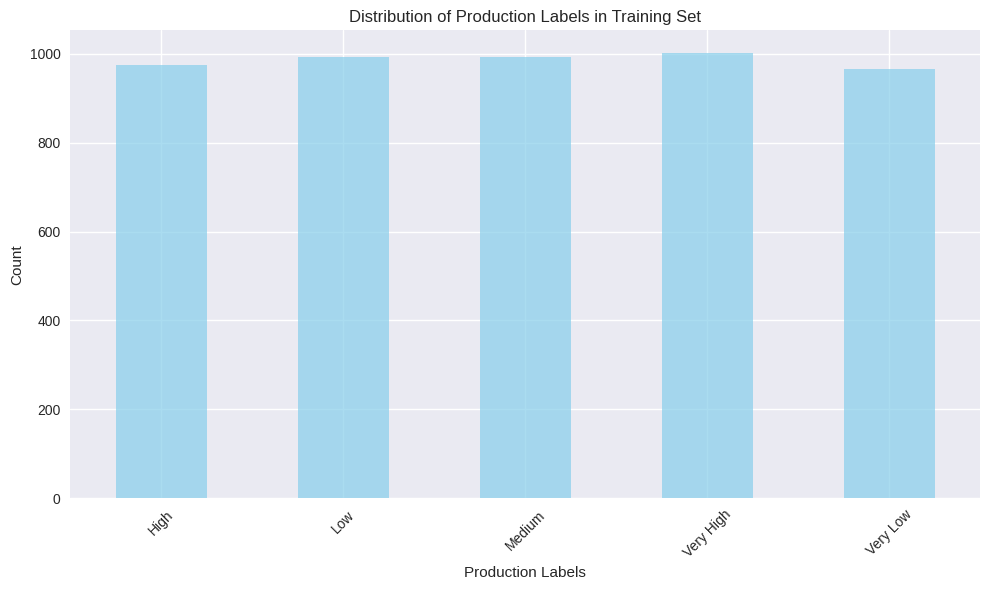


Preparing features and targets...
✅ Feature columns: ['Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)', 'Root Zone Soil Wetness (surface to 100 cm below)', 'soil_moisture_0_to_7cm(mÂ³/mÂ³)', 'Surface Soil Wetness (surface to 5 cm below)', 'soil_moiture_7_to_28cm(mÂ³/mÂ³)', 'total_rain_mm', 'relative_humidity_2m(%)', 'Precipitation Corrected (mm)', 'Crop_Beans', 'Crop_Bengal Spinach', 'Crop_Cabbage', 'Crop_Cauliflower', 'Crop_Garlic', 'Crop_Laushak', 'Crop_Onion', 'Crop_Rabi Brinjal', 'Crop_Radish', 'Crop_Tomato', 'District_Bagerhat', 'District_Bandarban', 'District_Barguna', 'District_Barishal', 'District_Bhola', 'District_Bogura', 'District_Brahmanbaria', 'District_Chandpur', 'District_Chapai Nawabganj', 'District_Chattogram', 'District_Chuadanga', 'District_Comilla', "District_Cox's Bazar", 'District_Dhaka', 'District_Dinajpur', 'District_Faridpur', 'District_Feni', 'District_Gaibandha', 'District_Gazipur', 'District_Gopalganj', 'District_H

In [4]:

# ========================================================================
# STEP 4: Create Labels and Prepare Features
# ========================================================================
print("STEP 4: Create quantile-based labels and prepare features...")
print("="*60)

# Create quantile-based labels
classifier._create_quantile_labels()

# Prepare features and targets
classifier._prepare_features_targets()
print("✅ Features and targets prepared successfully!")
print()


In [5]:

# ========================================================================
# STEP 5: Train the SVM Model
# ========================================================================
print("STEP 5: Train the SVM model...")
print("="*60)

# Train the model
classifier.train_model(kernel='rbf', C=1.0, gamma='scale')
print("✅ SVM model trained successfully!")
print()

STEP 5: Train the SVM model...

Training SVM model with kernel=rbf, C=1.0, gamma=scale...
✅ Features scaled successfully!
✅ Scaled training features shape: (4928, 85)
✅ Model training completed!
✅ SVM model trained successfully!



In [6]:

# ========================================================================
# STEP 6: Evaluate Model and Generate Confusion Matrices
# ========================================================================
print("STEP 6: Evaluate model and generate confusion matrices...")
print("="*60)

# Evaluate the model
classifier.evaluate_model()

STEP 6: Evaluate model and generate confusion matrices...

MODEL EVALUATION RESULTS
✅ Predictions generated for all datasets!

Training Set Metrics:
------------------------------
Accuracy: 0.8379
Precision (Macro): 0.8382
Recall (Macro): 0.8380
F1 Score (Macro): 0.8380
Precision (Weighted): 0.8383
Recall (Weighted): 0.8379
F1 Score (Weighted): 0.8380

Validation Set Metrics:
------------------------------
Accuracy: 0.7898
Precision (Macro): 0.7895
Recall (Macro): 0.7895
F1 Score (Macro): 0.7888
Precision (Weighted): 0.7910
Recall (Weighted): 0.7898
F1 Score (Weighted): 0.7897

Testing Set Metrics:
------------------------------
Accuracy: 0.7917
Precision (Macro): 0.7926
Recall (Macro): 0.7910
F1 Score (Macro): 0.7913
Precision (Weighted): 0.7931
Recall (Weighted): 0.7917
F1 Score (Weighted): 0.7919


In [7]:
# Generate detailed classification reports
classifier.detailed_classification_report()


DETAILED CLASSIFICATION REPORTS

Training Set Classification Report:
----------------------------------------
              precision    recall  f1-score   support

    Very Low       0.90      0.91      0.90       966
         Low       0.81      0.82      0.82       993
      Medium       0.81      0.79      0.80       992
        High       0.77      0.79      0.78       974
   Very High       0.90      0.88      0.89      1003

    accuracy                           0.84      4928
   macro avg       0.84      0.84      0.84      4928
weighted avg       0.84      0.84      0.84      4928


Validation Set Classification Report:
----------------------------------------
              precision    recall  f1-score   support

    Very Low       0.92      0.91      0.92       223
         Low       0.72      0.78      0.75       207
      Medium       0.75      0.68      0.71       223
        High       0.69      0.71      0.70       201
   Very High       0.88      0.87      0.87      


STEP 6: GENERATING CONFUSION MATRICES
✅ Confusion Matrix for Training Set:
[[875  76   8   7   0]
 [ 87 816  65  21   4]
 [  8  89 780 104  11]
 [  7  16  99 771  81]
 [  0   6   7 103 887]]

✅ Confusion Matrix for Validation Set:
[[204  18   1   0   0]
 [ 15 162  23   6   1]
 [  0  32 151  35   5]
 [  3  11  26 142  19]
 [  0   2   1  24 175]]

✅ Confusion Matrix for Testing Set:
[[193  24   2   1   1]
 [ 15 169  13   6   3]
 [  2  24 134  29   4]
 [  2   7  31 170  23]
 [  0   1   3  29 170]]



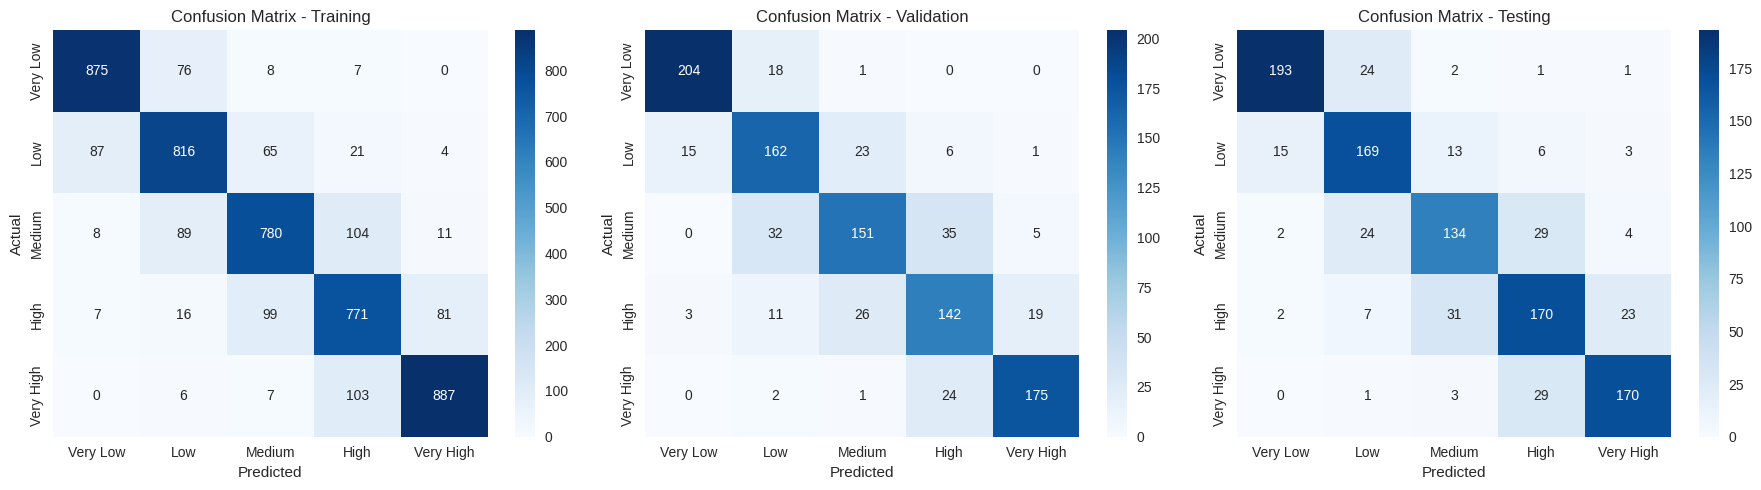

✅ Confusion matrices plotted successfully!


In [8]:

# Plot confusion matrices
classifier.plot_confusion_matrices()



STEP 7: ACCURACY AND F1 SCORE COMPARISON
✅ Accuracy scores: {'Training': '0.8379', 'Validation': '0.7898', 'Testing': '0.7917'}
✅ Macro F1 scores: {'Training': '0.8380', 'Validation': '0.7888', 'Testing': '0.7913'}


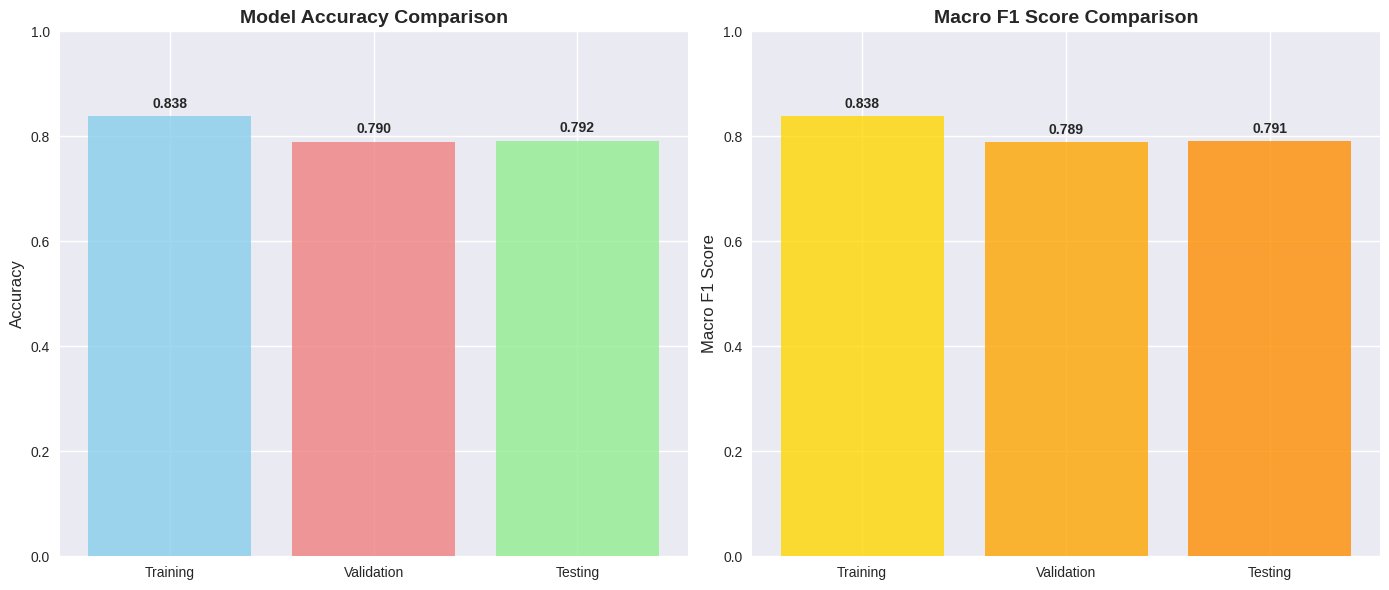

✅ Accuracy and F1 score comparison plotted successfully!


In [9]:

# ========================================================================
# STEP 7: Plot Accuracy and F1 Score Comparisons
# ========================================================================
classifier.plot_accuracy_comparison()



STEP 8: GENERATING LEARNING CURVES
Generating learning curves...
✅ Learning curve data generated!
✅ Training sizes: [ 394  788 1182 1576 1971 2365 2759 3153 3547 3942]
✅ Final training accuracy: 0.8333 ± 0.0029
✅ Final validation accuracy: 0.7778 ± 0.0160


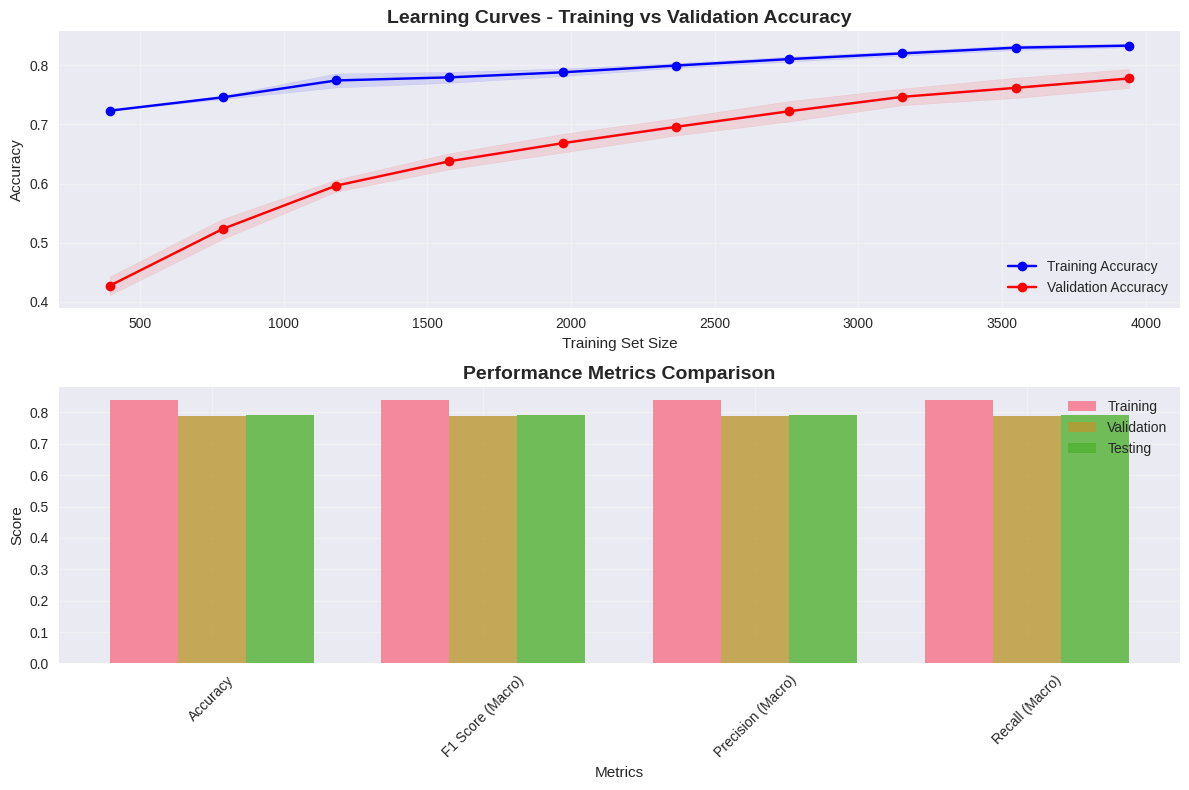

✅ Learning curves plotted successfully!


In [10]:

# ========================================================================
# STEP 8: Generate Learning Curves
# ========================================================================
classifier.plot_learning_curves()


In [11]:

# ========================================================================
# STEP 9: Create Final Summary Table
# ========================================================================
final_metrics = classifier.create_metrics_summary_table()



STEP 9: COMPREHENSIVE METRICS SUMMARY TABLE
✅ Metrics Summary Table:
            Accuracy  Precision (Macro)  Recall (Macro)  F1 Score (Macro)  Precision (Weighted)  Recall (Weighted)  F1 Score (Weighted)
Training      0.8379             0.8382          0.8380            0.8380                0.8383             0.8379               0.8380
Validation    0.7898             0.7895          0.7895            0.7888                0.7910             0.7898               0.7897
Testing       0.7917             0.7926          0.7910            0.7913                0.7931             0.7917               0.7919

PERFORMANCE HIGHLIGHTS
✅ Best Accuracy: 0.8379 (Training set)
✅ Best Macro F1 Score: 0.8380 (Training set)
✅ Best Weighted F1 Score: 0.8380 (Training set)


In [12]:

# ========================================================================
# STEP 10: Final Summary
# ========================================================================
print("\n" + "="*80)
print("STEP 10: FINAL SUMMARY")
print("="*80)
print("✅ MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print("✅ All visualizations generated!")
print("✅ All metrics calculated and displayed!")
print("="*80)

# Display model parameters
print(f"\nModel Parameters:")
print(f"- Kernel: {classifier.model.kernel}")
print(f"- C (Regularization): {classifier.model.C}")
print(f"- Gamma: {classifier.model.gamma}")
print(f"- Number of support vectors: {classifier.model.n_support_}")
print(f"- Number of classes: {len(classifier.label_mapping)}")
print()

print("🎉 SVM Classification Pipeline Completed Successfully! 🎉")


STEP 10: FINAL SUMMARY
✅ MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!
✅ All visualizations generated!
✅ All metrics calculated and displayed!

Model Parameters:
- Kernel: rbf
- C (Regularization): 1.0
- Gamma: scale
- Number of support vectors: [651 858 897 923 721]
- Number of classes: 5

🎉 SVM Classification Pipeline Completed Successfully! 🎉
